In [28]:
pip install pandas rdkit numpy openpyxl

Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd

# Load the CSV file
file_path_1 = "CHEMBL612532.csv"
file_path_2 = "CHEMBL614448.csv"

# Read the 1st CSV file
df1 = pd.read_csv(file_path_1, sep=";")
df1.columns = df1.columns.str.replace('"', '').str.strip() 

# Read the 2nd CSV file
df2 = pd.read_csv(file_path_2, sep=";")
df2.columns = df2.columns.str.replace('"', '').str.strip() 

# Combine both 
df = pd.concat([df1, df2])

# Check the total number of dataset
print(f"Total dataset imported: \n{len(df)}")

# Check the first few rows
print("First few rows of the dataset:")
print(df.head())

# Check the column names
print("Columns in CSV:", df.columns)

df.to_excel("S.typhi_MIC_Dataset.xlsx")


Total dataset imported: 
2596
First few rows of the dataset:
  Molecule ChEMBL ID Molecule Name  Molecule Max Phase  Molecular Weight  \
0       CHEMBL478315           NaN                 NaN            433.60   
1       CHEMBL521322           NaN                 NaN            476.92   
2       CHEMBL469088           NaN                 NaN            474.43   
3       CHEMBL514863           NaN                 NaN            419.57   
4       CHEMBL453967           NaN                 NaN            584.59   

   #RO5 Violations  AlogP Compound Key  \
0              0.0   3.79          15c   
1              0.0   4.60           5d   
2              0.0   4.46          17c   
3              0.0   3.54          14c   
4              2.0   3.06           6c   

                                              Smiles Standard Type  \
0  CC(C)C1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1...           MIC   
1  COC1(O)C(=O)c2ccccc2OC1(OC)c1cn(-c2ccccc2)nc1-...           MIC   
2  CC1C(=O)CC(c2ccc

In [30]:
# Check the column names
print("\nColumns in dataset:")
print(df.columns)

# Check the unique values in 'Standard Type' column
print("\nUnique values in 'Standard Type':")
print(df["Standard Type"].unique())

# Check what values are present in 'Standard Units'
print("\nUnique values in 'Standard Units':")
print(df["Standard Units"].unique())

# Check strings of Assay Description
print("\nUnique strings in 'Assay Descrption':")
print(df["Assay Description"].unique())



Columns in dataset:
Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Sta

In [31]:
import numpy as np

# Ensure column names are correct
mic_col = "Standard Value"  # MIC value column
units_col = "Standard Units"  # Unit of measurement column
mw_col = "Molecular Weight"  # Molecular weight column

# Convert MIC values to numeric
df[mic_col] = pd.to_numeric(df[mic_col], errors="coerce")
df[mw_col] = pd.to_numeric(df[mw_col], errors="coerce")  # Ensure MW is numeric

# Drop rows with missing MIC or MW values
df = df.dropna(subset=[mic_col, mw_col])

# Function to convert MIC values to µM
def convert_mic(value, unit, molecular_weight):
    """
    Converts MIC values to µM based on unit type.
    - Requires molecular weight for mass-based units (e.g., µg/mL, ppm, µg).
    - Units that cannot be converted return None.
    """
    if pd.isnull(unit) or unit.strip() == "nan":
        return None  # Skip NaN units

    unit = str(unit).strip()  # Convert to string and remove spaces

    # Direct unit conversions
    if unit == "nM":
        return value / 1000  # Convert nM to µM
    elif unit == "mM":
        return value * 1000  # Convert mM to µM
    elif unit == "10^-3mM":
        return value  # Already in µM
    elif unit == "10^2umol/ml":
        return value * 100  # Convert to µM

    # Mass-based conversions (require MW)
    if unit in ["ug.mL-1", "ug/mL", "ug l-1", "ug cm**-3", "microg/cm3", "ug m1 l-1"]:
        return (value / molecular_weight) * 1000  # Convert µg/mL to µM
    if unit in ["ug mg-1"]:
        return (value / molecular_weight) * 1000  # Convert µg to µM

    # ppm (parts per million) conversion (assumes density of water)
    if unit in ["ppm", "p.p.m."]:
        return (value / molecular_weight) * 1000  # Convert ppm to µM

    # Special cases
    if unit in ["10'-3micromol/ml", "10^-3micromol/ml", "10'-3uM/ml"]:
        return value * 0.001  # Convert to µM
    if unit in ["10'-2 umol/ml", "10'-2mmol/ml", "10'-2micromol/ml", "10'-2umol"]:
        return value * 10  # Convert to µM

    # Units that cannot be converted
    if unit in ["microg", "ug", "%", "uL/ml", "ug/disk", "ug disk-1", "IU/ml", "U ml-1", "ucm/s", "ug cm**-2", "ug/sq.cm"]:
        return None  # Not convertible

    # Log unknown unit for debugging
    print(f"Unknown unit: {unit}, value: {value}")
    return None  # Default to None if unit is unrecognized

# Apply conversion function
df["MIC_µM"] = df.apply(lambda row: convert_mic(row[mic_col], row[units_col], row[mw_col]), axis=1)

# Drop rows where conversion is not possible
df = df.dropna(subset=["MIC_µM"])

print(f"Remaining records after unit conversion: {len(df)}")
df.head()


Remaining records after unit conversion: 2463


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value,MIC_µM
0,CHEMBL478315,NaN,NaN,433.60,0.0,3.79,15c,CC(C)C1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,'=',...,1,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,50.00,115.313653
1,CHEMBL521322,NaN,NaN,476.92,0.0,4.60,5d,COC1(O)C(=O)c2ccccc2OC1(OC)c1cn(-c2ccccc2)nc1-...,MIC,'>',...,1,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,64.00,134.194414
2,CHEMBL469088,NaN,NaN,474.43,0.0,4.46,17c,CC1C(=O)CC(c2ccc(Cl)cc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,'=',...,1,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,12.50,26.347406
3,CHEMBL514863,NaN,NaN,419.57,0.0,3.54,14c,CCC1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1c1c...,MIC,'=',...,1,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,100.00,238.339252
4,CHEMBL453967,NaN,NaN,584.59,2.0,3.06,6c,COc1c(N2CCN(c3nnc(-c4ncc([N+](=O)[O-])n4C)s3)C...,MIC,'=',...,1,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,0.25,0.427650


In [32]:
# Check if columns exist
if "Standard Relation" not in df.columns or "MIC_µM" not in df.columns:
    raise KeyError("Columns 'Standard Relation' or 'MIC_µM' are missing from the DataFrame.")

# Ensure MIC_µM is numeric
df["MIC_µM"] = pd.to_numeric(df["MIC_µM"], errors="coerce")

# Check unique values in "Standard Relation"
df["Standard Relation"] = df["Standard Relation"].astype(str).str.strip().str.replace("'", "")
print("Cleaned Unique Standard Relation values:", df["Standard Relation"].unique())

def classify_activity(row):
    """
    Classifies compounds as 'Active' or 'Inactive' based on MIC_µM and Standard Relation.
    """
    mic_value = row["MIC_µM"]
    relation = row["Standard Relation"]
    
    # Skip missing values
    if pd.isnull(mic_value) or pd.isnull(relation):
        return np.nan  

    relation = relation.strip()  # Remove spaces
    relation = relation.replace("'", "")  # Remove extra quotes

    # Define classification based on relation type
    if relation in ["=", "<", "<="]:  # MIC is below or equal to cutoff
        return "Active" if mic_value < 100 else "Inactive"
    elif relation == ">":  # MIC is explicitly greater
        return "Inactive"
    elif relation == ">=":  # MIC is at least 50, consider inactive
        return "Inactive" if mic_value >= 100 else "Active"

    return np.nan  # If relation is unknown, return NaN

# Apply function
df["Activity_Label"] = df.apply(classify_activity, axis=1)

# Print activity counts
print("Compound activity distribution:")
print(df["Activity_Label"].value_counts(dropna=False))

# Display first few rows
df.head()


Cleaned Unique Standard Relation values: ['=' '>' '<=' '<']
Compound activity distribution:
Activity_Label
Inactive    1413
Active      1050
Name: count, dtype: int64


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value,MIC_µM,Activity_Label
0,CHEMBL478315,NaN,NaN,433.60,0.0,3.79,15c,CC(C)C1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,50.00,115.313653,Inactive
1,CHEMBL521322,NaN,NaN,476.92,0.0,4.60,5d,COC1(O)C(=O)c2ccccc2OC1(OC)c1cn(-c2ccccc2)nc1-...,MIC,>,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,64.00,134.194414,Inactive
2,CHEMBL469088,NaN,NaN,474.43,0.0,4.46,17c,CC1C(=O)CC(c2ccc(Cl)cc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,12.50,26.347406,Active
3,CHEMBL514863,NaN,NaN,419.57,0.0,3.54,14c,CCC1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1c1c...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,100.00,238.339252,Inactive
4,CHEMBL453967,NaN,NaN,584.59,2.0,3.06,6c,COc1c(N2CCN(c3nnc(-c4ncc([N+](=O)[O-])n4C)s3)C...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,0.25,0.427650,Active


In [33]:
from rdkit import Chem
from rdkit.Chem import SaltRemover
import re  # Needed to check for stereochemistry in SMILES

# Define valid atoms for organic compounds
valid_atoms = {"H", "C", "N", "O", "F", "P", "S", "Cl", "Br", "I"}  # Common organic elements
remover = SaltRemover.SaltRemover()

# Ensure "Smiles" column exists
if "Smiles" not in df.columns:
    raise KeyError("The column 'Smiles' does not exist in the DataFrame. Check the CSV file!")

# Remove missing/empty SMILES values
df = df.dropna(subset=["Smiles"])
df = df[df["Smiles"].str.strip() != ""]

# Function to check molecular validity (removes salts, racemates, and non-organic compounds)
def is_valid_organic(smiles):
    try:
        if pd.isnull(smiles) or smiles.strip() == "":
            return False  # Skip empty values
        
        mol = Chem.MolFromSmiles(str(smiles))  # Convert SMILES to RDKit Mol
        if mol is None:
            return False  # Invalid molecule
        
        # Remove salts
        mol = remover.StripMol(mol, dontRemoveEverything=True)
        if mol is None or mol.GetNumAtoms() == 0:
            return False  # If salt removal leaves nothing, discard
        
        # Ensure only valid organic elements are present
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}  # Extract atomic symbols
        if not elements.issubset(valid_atoms):
            return False  # Remove if non-organic elements are found
        
        # Remove racemic mixtures (Only keep molecules with NO chiral centers)
        if any(atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED for atom in mol.GetAtoms()):
            return False  # Discard molecules with chiral centers (potential racemic mixture)
        
        # Remove molecules with explicit stereochemistry in SMILES
        if re.search(r"[@\\/]", smiles):  # Detect '@' (chirality) and '/' or '\' (double bond stereo)
            return False  # Remove molecules with stereochemical annotations
        
        return True  # Valid molecule
    
    except Exception as e:
        print(f"Error processing SMILES '{smiles}': {e}")
        return False

# Apply function to filter molecules
df["is_valid_molecule"] = df["Smiles"].apply(lambda x: is_valid_organic(x) if pd.notnull(x) else False)

# Print molecule validity counts
print("Valid molecules count:", df["is_valid_molecule"].sum())
print("Invalid molecules count:", (~df["is_valid_molecule"]).sum())

# Filter dataset to keep only valid organic compounds (remove racemic & salts)
df = df[df["is_valid_molecule"]].drop(columns=["is_valid_molecule"], errors="ignore")

# Final dataset summary
print(f"Number of remaining compounds after filtering: {len(df)}")
df.head()

Valid molecules count: 1560
Invalid molecules count: 903
Number of remaining compounds after filtering: 1560


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value,MIC_µM,Activity_Label
0,CHEMBL478315,NaN,NaN,433.60,0.0,3.79,15c,CC(C)C1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,50.00,115.313653,Inactive
1,CHEMBL521322,NaN,NaN,476.92,0.0,4.60,5d,COC1(O)C(=O)c2ccccc2OC1(OC)c1cn(-c2ccccc2)nc1-...,MIC,>,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,64.00,134.194414,Inactive
2,CHEMBL469088,NaN,NaN,474.43,0.0,4.46,17c,CC1C(=O)CC(c2ccc(Cl)cc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,12.50,26.347406,Active
3,CHEMBL514863,NaN,NaN,419.57,0.0,3.54,14c,CCC1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1c1c...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,100.00,238.339252,Inactive
4,CHEMBL453967,NaN,NaN,584.59,2.0,3.06,6c,COc1c(N2CCN(c3nnc(-c4ncc([N+](=O)[O-])n4C)s3)C...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,0.25,0.427650,Active


In [13]:
'''
import pandas as pd

# Function to classify S. typhi strains based on assay description
def classify_strain(description):
    if pd.isna(description):  # Handle missing values
        return "Unclassified"
    
    description = description.lower()  # Convert to lowercase for case-insensitive matching

    # MDR (Multidrug-Resistant) Keywords
    mdr_keywords = ["multidrug-resistant", "mdr", "drug-resistant", "bla ctx-m-15", "beta-lactamase producing", "bla ctx-m", "ich", 
                    "mtcc 734", "resistant to ampicillin", "resistant to chloramphenicol", "resistant to trimethoprim-sulfamethoxazole",
                    "ich 098", "mtcc 734", "h901", "080048ty"]

    # XDR (Extensively Drug-Resistant) Keywords
    xdr_keywords = ["extensively drug-resistant", "xdr", "resistant to all first-line antibiotics", "080048ty", "080049ty",  "x514", 
                    "resistant to ceftriaxone", "resistant to ciprofloxacin", "bla ctx-m-15", "bla ctx-m-15 + clavulanic acid"]

    # Classification Logic
    if any(keyword in description for keyword in xdr_keywords):
        return "XDR S. typhi"
    elif any(keyword in description for keyword in mdr_keywords):
        return "MDR S. typhi"
    else:
        return "Non-resistant S.typhi"

# Apply classification to your actual DataFrame
df["Strain_Type"] = df["Assay Description"].apply(classify_strain)

# Print summary of classification counts
print(df["Strain_Type"].value_counts())

# Save the updated DataFrame (optional)
# df.to_csv("classified_output.csv", index=False)
'''

'\nimport pandas as pd\n\n# Function to classify S. typhi strains based on assay description\ndef classify_strain(description):\n    if pd.isna(description):  # Handle missing values\n        return "Unclassified"\n    \n    description = description.lower()  # Convert to lowercase for case-insensitive matching\n\n    # MDR (Multidrug-Resistant) Keywords\n    mdr_keywords = ["multidrug-resistant", "mdr", "drug-resistant", "bla ctx-m-15", "beta-lactamase producing", "bla ctx-m", "ich", \n                    "mtcc 734", "resistant to ampicillin", "resistant to chloramphenicol", "resistant to trimethoprim-sulfamethoxazole",\n                    "ich 098", "mtcc 734", "h901", "080048ty"]\n\n    # XDR (Extensively Drug-Resistant) Keywords\n    xdr_keywords = ["extensively drug-resistant", "xdr", "resistant to all first-line antibiotics", "080048ty", "080049ty",  "x514", \n                    "resistant to ceftriaxone", "resistant to ciprofloxacin", "bla ctx-m-15", "bla ctx-m-15 + clavulanic

In [34]:

# Remove Duplicates
df = df.drop_duplicates()

# Remove all listed as unclassified
#df = df.drop(df[df['Strain_Type'] == 'Unclassified'].index)

# Remove all inactive
#df = df.drop(df[df['Activity_Label'] == 'Inactive'].index)

print(f"Remaining records after removing conflicts and duplicates: {len(df)}")
#print(df["Strain_Type"].value_counts())
print(df["Activity_Label"].value_counts(dropna=False))
df.head()


Remaining records after removing conflicts and duplicates: 1560
Activity_Label
Inactive    958
Active      602
Name: count, dtype: int64


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value,MIC_µM,Activity_Label
0,CHEMBL478315,NaN,NaN,433.60,0.0,3.79,15c,CC(C)C1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,50.00,115.313653,Inactive
1,CHEMBL521322,NaN,NaN,476.92,0.0,4.60,5d,COC1(O)C(=O)c2ccccc2OC1(OC)c1cn(-c2ccccc2)nc1-...,MIC,>,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,64.00,134.194414,Inactive
2,CHEMBL469088,NaN,NaN,474.43,0.0,4.46,17c,CC1C(=O)CC(c2ccc(Cl)cc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,12.50,26.347406,Active
3,CHEMBL514863,NaN,NaN,419.57,0.0,3.54,14c,CCC1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1c1c...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,100.00,238.339252,Inactive
4,CHEMBL453967,NaN,NaN,584.59,2.0,3.06,6c,COc1c(N2CCN(c3nnc(-c4ncc([N+](=O)[O-])n4C)s3)C...,MIC,=,...,Scientific Literature,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,0.25,0.427650,Active


In [35]:
df.to_excel("Finalized_S.typhi_MIC_Dataset.xlsx")

In [36]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

# Function to process molecules
def process_molecule(smiles):
    try:
        # Step 1: Convert SMILES to RDKit Molecule
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Step 2: Standardize the molecule (remove salts, normalize tautomers)
        normalizer = rdMolStandardize.Normalizer()
        mol = normalizer.normalize(mol)

        # Step 3: Adjust protonation state (pH 7.4 equivalent to QUACPAC fixpka)
        uncharger = rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)  # Removes extra charges

        # 🔹 SANITIZE after modifications to avoid RingInfo errors
        Chem.SanitizeMol(mol)

        # Step 4: Generate 3D Conformer (RDKit alternative to OMEGA)
        mol = Chem.AddHs(mol)  # Add explicit hydrogens
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D conformer
        AllChem.UFFOptimizeMolecule(mol)  # Optimize geometry

        # 🔹 SANITIZE again to ensure correctness after 3D processing
        Chem.SanitizeMol(mol)

        return mol  # Return processed molecule

    except Exception as e:
        print(f"Error processing molecule {smiles}: {e}")
        return None

# Apply function to your dataset
df["Processed_Molecule"] = df["Smiles"].apply(process_molecule)

# Drop rows where processing failed
df = df.dropna(subset=["Processed_Molecule"])

print(f"Processed {len(df)} molecules successfully!")
df.head()

[04:19:04] Initializing Normalizer
[04:19:04] Running Normalizer
[04:19:04] Running Uncharger
[04:19:04] Initializing Normalizer
[04:19:04] Running Normalizer
[04:19:04] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:05] Initializing Normalizer
[04:19:05] Running Normalizer
[04:19:05] Running Uncharger
[04:19:06] Initializing Normalizer
[04:19:06] Running Normalizer
[04:19:06] Running Uncharger
[04:19:06] Initializing Normalizer
[04:19:06] Running Normal

Error processing molecule CCCCCCCCCCCCCCCCn1c(COc2c(OC)ccc3cc4[n+](cc23)CCc2cc3c(cc2-4)OCO3)nc2ccccc21.[Cl-]: Bad Conformer Id


[04:19:34] Initializing Normalizer
[04:19:34] Running Normalizer
[04:19:34] Running Uncharger
[04:19:34] Initializing Normalizer
[04:19:34] Running Normalizer
[04:19:34] Running Uncharger
[04:19:34] Initializing Normalizer
[04:19:34] Running Normalizer
[04:19:34] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normalizer
[04:19:35] Running Uncharger
[04:19:35] Initializing Normalizer
[04:19:35] Running Normal

Error processing molecule CCCCCCCCn1c(COc2c(OC)ccc3cc4[n+](cc23)CCc2cc3c(cc2-4)OCO3)nc2ccccc21.[Cl-]: Bad Conformer Id


[04:20:01] Initializing Normalizer
[04:20:01] Running Normalizer
[04:20:01] Running Uncharger
[04:20:01] Initializing Normalizer
[04:20:01] Running Normalizer
[04:20:01] Running Uncharger
[04:20:01] Initializing Normalizer
[04:20:01] Running Normalizer
[04:20:01] Running Uncharger
[04:20:01] Initializing Normalizer
[04:20:01] Running Normalizer
[04:20:01] Running Uncharger
[04:20:01] Initializing Normalizer
[04:20:01] Running Normalizer
[04:20:01] Running Uncharger
[04:20:02] Initializing Normalizer
[04:20:02] Running Normalizer
[04:20:02] Running Uncharger
[04:20:02] Initializing Normalizer
[04:20:02] Running Normalizer
[04:20:02] Running Uncharger
[04:20:02] Initializing Normalizer
[04:20:02] Running Normalizer
[04:20:02] Running Uncharger
[04:20:02] Initializing Normalizer
[04:20:02] Running Normalizer
[04:20:02] Running Uncharger
[04:20:02] Initializing Normalizer
[04:20:02] Running Normalizer
[04:20:02] Running Uncharger
[04:20:02] Initializing Normalizer
[04:20:02] Running Normal

Error processing molecule O=C1c2cccc3c(Br)ccc(c23)C(=O)N1CCCCCCn1cc[n+](Cc2ccc(F)cc2F)c1.[Br-]: Bad Conformer Id


[04:20:39] Initializing Normalizer
[04:20:39] Running Normalizer
[04:20:39] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:40] Initializing Normalizer
[04:20:40] Running Normalizer
[04:20:40] Running Uncharger
[04:20:41] Initializing Normalizer
[04:20:41] Running Normalizer
[04:20:41] Running Uncharger
[04:20:41] Initializing Normalizer
[04:20:41] Running Normalizer
[04:20:41] Running Uncharger
[04:20:41] Initializing Normalizer
[04:20:41] Running Normal

Error processing molecule CCCCCCCCCCCCCCCCCCn1c(COc2c(OC)ccc3cc4[n+](cc23)CCc2cc3c(cc2-4)OCO3)nc2ccccc21.[Cl-]: Bad Conformer Id


[04:22:06] Initializing Normalizer
[04:22:06] Running Normalizer
[04:22:06] Running Uncharger
[04:22:06] Initializing Normalizer
[04:22:06] Running Normalizer
[04:22:06] Running Uncharger
[04:22:06] Initializing Normalizer
[04:22:06] Running Normalizer
[04:22:06] Running Uncharger
[04:22:06] Initializing Normalizer
[04:22:06] Running Normalizer
[04:22:06] Running Uncharger
[04:22:06] Initializing Normalizer
[04:22:06] Running Normalizer
[04:22:06] Running Uncharger
[04:22:06] Initializing Normalizer
[04:22:06] Running Normalizer
[04:22:06] Running Uncharger
[04:22:07] Initializing Normalizer
[04:22:07] Running Normalizer
[04:22:07] Running Uncharger
[04:22:07] Initializing Normalizer
[04:22:07] Running Normalizer
[04:22:07] Running Uncharger
[04:22:07] Initializing Normalizer
[04:22:07] Running Normalizer
[04:22:07] Running Uncharger
[04:22:07] Initializing Normalizer
[04:22:07] Running Normalizer
[04:22:07] Running Uncharger
[04:22:07] Initializing Normalizer
[04:22:07] Running Normal

Processed 1556 molecules successfully!


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value,MIC_µM,Activity_Label,Processed_Molecule
0,CHEMBL478315,NaN,NaN,433.60,0.0,3.79,15c,CC(C)C1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,50.00,115.313653,Inactive,<rdkit.Chem.rdchem.Mol object at 0x740c2bdfa5e0>
1,CHEMBL521322,NaN,NaN,476.92,0.0,4.60,5d,COC1(O)C(=O)c2ccccc2OC1(OC)c1cn(-c2ccccc2)nc1-...,MIC,>,...,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,64.00,134.194414,Inactive,<rdkit.Chem.rdchem.Mol object at 0x740c2bdfa650>
2,CHEMBL469088,NaN,NaN,474.43,0.0,4.46,17c,CC1C(=O)CC(c2ccc(Cl)cc2)N(C(=O)CN2CCN(C)CC2)C1...,MIC,=,...,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,12.50,26.347406,Active,<rdkit.Chem.rdchem.Mol object at 0x740c2bdfa730>
3,CHEMBL514863,NaN,NaN,419.57,0.0,3.54,14c,CCC1C(=O)CC(c2ccccc2)N(C(=O)CN2CCN(C)CC2)C1c1c...,MIC,=,...,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,100.00,238.339252,Inactive,<rdkit.Chem.rdchem.Mol object at 0x740c2bdfa7a0>
4,CHEMBL453967,NaN,NaN,584.59,2.0,3.06,6c,COc1c(N2CCN(c3nnc(-c4ncc([N+](=O)[O-])n4C)s3)C...,MIC,=,...,Eur J Med Chem,2009,NaN,NaN,NaN,NaN,0.25,0.427650,Active,<rdkit.Chem.rdchem.Mol object at 0x740c2bdfa6c0>


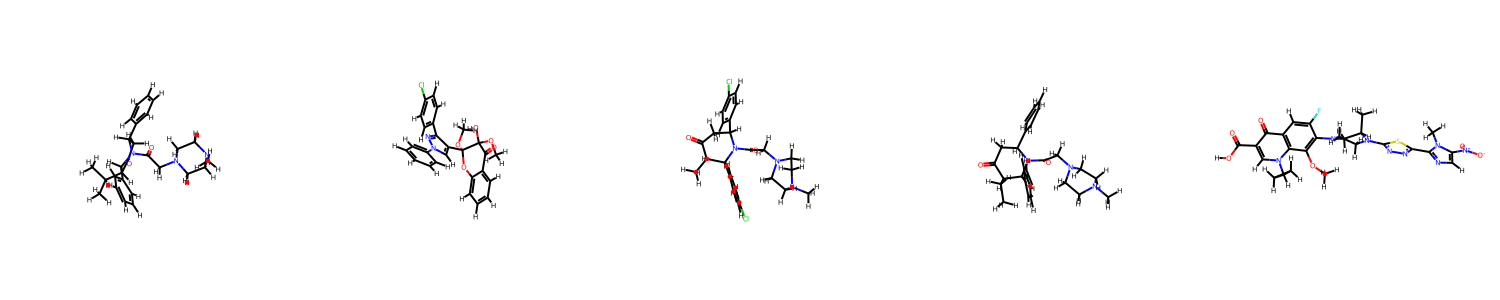

In [37]:
from rdkit.Chem import Draw

# Show first 5 molecules
Draw.MolsToGridImage(df["Processed_Molecule"].head(5), molsPerRow=5, subImgSize=(300, 300))


In [38]:
df.to_csv("S.typhi_MIC_Dataset_Processed.csv")

In [39]:
# Convert to numeric: "active" → 1, "inactive" → 0
df['Activity_Label'] = df['Activity_Label'].map({'Active': 1, 'Inactive': 0})

# Print result
print(df['Activity_Label'])

0       0
1       0
2       1
3       0
4       1
       ..
2563    1
2564    1
2565    1
2566    1
2567    0
Name: Activity_Label, Length: 1556, dtype: int64


In [40]:
import os
from rdkit import Chem

# Ensure output directory exists
output_folder = "mol_files"
os.makedirs(output_folder, exist_ok=True)

# Define SDF file path
sdf_filename = os.path.join(output_folder, "molecules.sdf")

# Create an SDF writer
writer = Chem.SDWriter(sdf_filename)

# Loop through DataFrame and save each molecule with properties
for idx, row in df.dropna(subset=["Processed_Molecule"]).iterrows():
    mol = row["Processed_Molecule"]
    if mol is not None:
        # Add activity/property fields (modify this based on actual column names)
        if "Activity_Label" in row:
            mol.SetProp("Activity_Label", str(row["Activity_Label"]))
        if "MIC_µM" in row:
            mol.SetProp("MIC_µM", str(row["MIC_µM"]))
        if "AlogP" in row:
            mol.SetProp("AlogP", str(row["AlogP"]))
        if "#RO5 Violations" in row:
            mol.SetProp("#RO5 Violations", str(row["#RO5 Violations"]))
        if "Molecular Weight" in row:
            mol.SetProp("Molecular Weight", str(row["Molecular Weight"]))
        
        # Write to SDF
        writer.write(mol)

# Close writer
writer.close()

print(f"Saved {len(df.dropna(subset=['Processed_Molecule']))} molecules with activity data in SDF format!")


Saved 1556 molecules with activity data in SDF format!


In [41]:
from rdkit import Chem

# Load SDF file correctly
suppl = Chem.SDMolSupplier("molecules.sdf", removeHs=False, sanitize=True)

# Convert molecules to RDKit Mol objects (skipping None values)
molecules = [mol for mol in suppl if mol is not None]

print(f"Loaded {len(molecules)} valid molecules.")


[04:22:34] Skipping unrecognized collection type at line 3636: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 3868: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 6619: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 6765: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 7765: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 8240: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 8384: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 8621: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 10901: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 15000: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collection type at line 15163: MDLV30/STEABS ATOMS=(0)
[04:22:34] Skipping unrecognized collect

Loaded 1559 valid molecules.


In [42]:
import os
from rdkit import Chem

output_folder = "mol_files"
os.makedirs(output_folder, exist_ok=True)  # Create folder if not exists

# Loop through DataFrame and save each molecule
for idx, mol in enumerate(df["Processed_Molecule"].dropna()):
    mol_filename = os.path.join(output_folder, f"molecule_{idx+1}.mol")
    Chem.MolToMolFile(mol, mol_filename)

print(f"Saved {len(df['Processed_Molecule'].dropna())} molecules in MOL format!")


Saved 1556 molecules in MOL format!


In [43]:
df.to_csv("S.typhi_MIC_Dataset_Processed.csv")